### Text Summarization

Automatic text summarization is the task of producing a concise and fluent summary while preserving key information content and overall meaning of the original text.


### Aproaches to Text Summarization
1. Extractive Summarization
2. Abstractive Summarization


### Extractive Summarization

These methods rely on extracting several parts, such as phrases and sentences, from a piece of text and stack them together to create a summary. Therefore, identifying the right sentences for summarization is of utmost importance in an extractive method.

With this strategy we identify the important sentences or phrases from the original text and extract only those from the text. **Note:** _that those extracted sentences would be our summary_

Example:

Text:
```
there are two boys.
the two boys climps a tree.
these boys are sitting in the tree.
```

Summary:
```
there are two boys. (sentence 1)
these boys are sitting in the tree. (sentence 3)
```

### Abstractive Summarization

These methods use advanced NLP techniques to generate an entirely new summary. Some parts of this summary may not even appear in the original text.

Here, we generate new sentences from the original text. This is in contrast to the extractive approach we saw earlier where we used only the sentences that were present. _The sentences generated through abstractive summarization might not be present in the original text_.

Text:
```
there are two boys.
the two boys climps a tree.
these boys are sitting in the tree.
```

Summary:
```
the boys spend their day in a tree.
```

### Seq2Seq In Text summarization
We are going to use Seq2Seq approach to help us solve our problem of text summarization. We can model this as a **Many-to-Many** Seq2Seq problem.

![img](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/final.jpg)

The `seq2seq` (encoder-decoder achitecture) is made up of two major components which are:

1. Encoder
2. Decoder


> _The Encoder-Decoder architecture is mainly used to solve the sequence-to-sequence (Seq2Seq) problems where the input and output sequences are of different lengths_. 

_Generally, variants of Recurrent Neural Networks (RNNs), i.e. Gated Recurrent Unit (GRU) or Long Short Term Memory (LSTM), are preferred as the encoder and decoder components. This is because they are capable of capturing long term dependencies by overcoming the problem of vanishing gradient._

The Encoder Decoder model can be seted up in 2 phases.

1. Train phase
2. Inference phase.


### Train phase

### Encoder

An Encoder Long Short Term Memory model (LSTM) reads the entire input sequence wherein, at each timestep, one word is fed into the encoder. It then processes the information at every timestep and captures the contextual information present in the input sequence.

The hidden state (hi) and cell state (ci) of the last time step are used to initialize the decoder. Remember, this is because the encoder and decoder are two different sets of the LSTM architecture.

### Decoder

The decoder is also an LSTM network which reads the entire target sequence word-by-word and predicts the same sequence offset by one timestep. The decoder is trained to predict the next word in the sequence given the previous word.

`<start>` and `<end>` are the special tokens which are added to the target sequence before feeding it into the decoder. The target sequence is unknown while decoding the test sequence. So, we start predicting the target sequence by passing the first word into the decoder which would be always the ``<start> `` token. And the ``<end>`` token signals the end of the sentence.

### Inference phase
After training, the model is tested on new source sequences for which the target sequence is unknown. So, we need to set up the inference architecture to decode a test sequence:

![img](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/82.jpg)

#### How does the inference process work?

1. Encode the entire input sequence and initialize the decoder with internal states of the encoder
2. Pass the `<start>` token as the input to the decoder.
3. Run the decoder for one timestep with the internal states
4. The output will be the probability for the next word. The word with the maximum probability will be selected
5. Pass the sampled word as an input to the decoder in the next timestep and update the internal states with the current time step
6. Repeat steps 3 – 5 until we generate ``<end>`` token or hit the maximum length of the target sequence


### Limitations of the Encoder-Decoder Achitecture.
1. The encoder converts the entire input sequence into a fixed length vector and then the decoder predicts the output sequence. This works only for short sequences since the decoder is looking at the entire input sequence for the prediction
2. Here comes the problem with long sequences. It is difficult for the encoder to memorize long sequences into a fixed length vector

...

> _“A potential issue with this encoder-decoder approach is that a neural network needs to be able to compress all the necessary information of a source sentence into a fixed-length vector. This may make it difficult for the neural network to cope with long sentences. The performance of a basic encoder-decoder deteriorates rapidly as the length of an input sentence increases.” - **Neural Machine Translation by Jointly Learning to Align and Translate_**


### How do we solve this problem?

This is where the concept of **Attention Mechanism** comes into the picture. It aims to predict a word by looking at a few specific parts of the sequence only, rather than the entire sequence.


### Attention Mechanism

How much attention do we need to pay to every word in the input sequence for generating a word at timestep $t$? 


### Different attention mechanisim

1. Global Attention
Here, the attention is placed on all the source positions. In other words, all the hidden states of the encoder are considered for deriving the attended context vector:

![img](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/121.jpg)

2. Local Attention
Here, the attention is placed on only a few source positions. Only a few hidden states of the encoder are considered for deriving the attended context vector:

![img](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/05/131.jpg)


### Solving the problem

We are going to use [this dataset from kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews/version/2). So what i will do is to download the dataset and upload it on my google drive so that it can be loaded eaisly on google colab.


### Mounting the drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
file_path = "/content/drive/My Drive/NLP Data/text-sum/amazon-fine-food-reviews/Reviews.csv"

os.path.exists(file_path)

True

### Imports

In [3]:
import tensorflow as tf
from tensorflow import keras

import nltk
nltk.download("punkt")
import numpy as np
import pandas as pd
import re

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords  
from tensorflow.python.keras import backend as K

tf.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'2.6.0'

### Dataset

> _This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories._


We are not going to use the whole dataset. We are only going to use 100,000 review in this example.

In [4]:
data = pd.read_csv(file_path, nrows=100_000)
data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


### Dropping duplicates and na values

In [5]:
data.drop_duplicates(subset=["Text"], inplace=True)
data.dropna(axis=0, inplace=True)

### Preprocessing the data

We are going to expand teh contracted words for example `ain't` is `is not`. So for that we are going to create a `contraction_mapping` which is essentally a dictionary mapping that contains contracted words with their expanded words.

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"
}

### Text cleaning
 We are going to perform the following text cleaning steps to our data.

1. Convert everything to lowercase
2. Remove HTML tags
3. Contraction mapping
4. Remove (‘s)
5. Remove any text inside the parenthesis ( )
6. Eliminate punctuations and special characters
7. Remove stopwords
8. Remove short words

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
list(stop_words)[:3]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['ourselves', "didn't", 'theirs']

In [8]:
from bs4 import BeautifulSoup

In [9]:
def text_cleaner(text):
  text = text.lower()
  text = BeautifulSoup(text, "lxml").text
  text = re.sub(r'\([^)]*\)', '', text)
  text = re.sub('"','', text)
  text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")]
                  )
  text = re.sub(r"'s\b","",text)
  text = re.sub("[^a-zA-Z]", " ", text)
  tokens = [w for w in text.split() if not w in stop_words]
  long_words=[]
  for i in tokens:
    if len(i) > 2:
      long_words.append(i)
  return " ".join(long_words).strip()

In [10]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [11]:
cleaned_text[:3]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch']

### Summary cleaning 

In [12]:
def summary_cleaner(text):
    text = re.sub('"','', text)
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])    
    text = re.sub(r"'s\b","",text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    tokens=text.split()
    text=''
    for i in tokens:
        if len(i)>1:                                 
            text=text+i+' '  
    return text.strip()

In [13]:
cleaned_summary = []
for t in data['Summary']:
  cleaned_summary.append(summary_cleaner(t))

cleaned_summary[:3]

['good quality dog food', 'not as advertised', 'delight says it all']

### Creating new columns to our dataframe `data`

In [14]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

### Adding `<sos>` and `<eos>` tokens to the summary.

* `<sos>` - start of sequence(sentence)
* `<eos>` - end of sequence(sentence)

In [15]:
add_special_tokens = lambda x: f"<sos> {x} <eos>" 
data['cleaned_summary'] = data['cleaned_summary'].apply(add_special_tokens)

In [16]:
data['cleaned_summary'][:2]

0    <sos> good quality dog food <eos>
1        <sos> not as advertised <eos>
Name: cleaned_summary, dtype: object

### Checking the to 5 revies with their summary

In [17]:
for i in range(5):
  print("Review:",data['cleaned_text'][i])
  print("Summary:",data['cleaned_summary'][i])
  print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: <sos> good quality dog food <eos>


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: <sos> not as advertised <eos>


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: <sos> delight says it all <eos>


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: <sos> cough medicine <eos>


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Sum

### Understanding the distribution of the data.

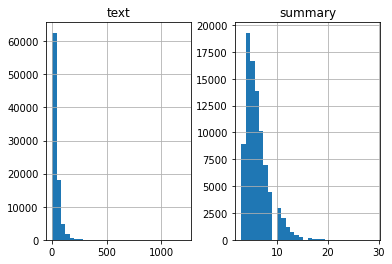

In [18]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
  text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
  summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [19]:
max(summary_word_count), max(text_word_count)

(29, 1212)

We can fix the maximum length of the reviews to 80 since that seems to be the majority review length. Similarly, we can set the maximum summary length to 10:

In [20]:
max_len_text=80 
max_len_summary=10

### Splitting the data

We are going to split our dataset into three sets:

1. train set
2. test set
3. validation set


In [21]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(
    data['cleaned_text'].values,
    data['cleaned_summary'].values,
    test_size=.1,
    random_state=42,
    shuffle=True
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=.1,
    random_state=42,
    shuffle=True
)

### Checking examples

In [27]:
from prettytable import PrettyTable
def tabulate(column_names, data):
  table = PrettyTable(column_names)
  table.title= "VISUALIZING SETS EXAMPLES"
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

column_names = ["SUBSET", "EXAMPLE(s)"]
row_data = [
        ["training", len(x_train)],
        ['validation', len(x_val)],
        ['test', len(x_test)]
]
tabulate(column_names, row_data)

+-----------------------------+
|  VISUALIZING SETS EXAMPLES  |
+--------------+--------------+
| SUBSET       |   EXAMPLE(s) |
+--------------+--------------+
| training     |        71564 |
| validation   |         7952 |
| test         |         8836 |
+--------------+--------------+


### Tokenizers

A tokenizer build the word vocabulary and converts the word sequences to integer sequences.


1. Text Tokenizer

In [29]:
text_tokenizer = Tokenizer(num_words=None)
text_tokenizer.fit_on_texts(list(x_train))

2. Summary Tokenizer

In [30]:
summary_tokenizer = Tokenizer(num_words=None)
summary_tokenizer.fit_on_texts(list(y_train))

### Tokens to sequences


In [31]:
# Features

x_train_tokens = text_tokenizer.texts_to_sequences(
    x_train
)
x_val_tokens = text_tokenizer.texts_to_sequences(
    x_val
)
x_test_tokens = text_tokenizer.texts_to_sequences(
    x_test
)

# Labels

y_train_tokens = summary_tokenizer.texts_to_sequences(
    y_train
)
y_val_tokens = summary_tokenizer.texts_to_sequences(
    y_val
)
y_test_tokens = summary_tokenizer.texts_to_sequences(
    y_test
)


### Padding the sequences.

In [33]:
# features

x_train_tokens = pad_sequences(
    x_train_tokens,
    maxlen=max_len_text, padding='post',
    truncating="post"
)
x_val_tokens = pad_sequences(
    x_val_tokens,
    maxlen=max_len_text, padding='post',
    truncating="post"
)
x_test_tokens =  pad_sequences(
    x_test_tokens,
    maxlen=max_len_text, padding='post',
    truncating="post"
)

# labels

y_train_tokens = pad_sequences(
    y_train_tokens,
    maxlen=max_len_summary, padding='post',
    truncating="post"
)
y_val_tokens = pad_sequences(
    y_val_tokens,
    maxlen=max_len_summary, padding='post',
    truncating="post"
)
y_test_tokens =  pad_sequences(
    y_test_tokens,
    maxlen=max_len_summary, padding='post',
    truncating="post"
)

In [34]:
y_test_tokens[:10]

array([[  1, 632,   2,   0,   0,   0,   0,   0,   0,   0],
       [  1,  24, 123,   7,  25,   2,   0,   0,   0,   0],
       [  1,  10, 212,  39,   2,   0,   0,   0,   0,   0],
       [  1,   7,  37,   5,  37,  98,  15, 783,   2,   0],
       [  1,   3,  20,  12, 102,  36, 143, 341,   2,   0],
       [  1,  23,  29,  89,   2,   0,   0,   0,   0,   0],
       [  1,  40, 638,  78, 154,  14,  42, 113,   2,   0],
       [  1,  72,   2,   0,   0,   0,   0,   0,   0,   0],
       [  1, 254, 158,   2,   0,   0,   0,   0,   0,   0],
       [  1,  34,   2,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

### Vocabulary sizes

We are going to calculate the vocabulary size for both the features and labels. WE are going to add 1 to the vocabulary size for the `<unk>` token.

In [37]:
summary_vocab_size  =   len(summary_tokenizer.word_index) +1
text_vocab_size  =   len(text_tokenizer.word_index) + 1

summary_vocab_size, text_vocab_size

(13361, 49094)

### Building the model

Before we build the model let's understand something.


* *Return Sequences = True*: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

* *Return State = True*: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

* *Initial State*: This is used to initialize the internal states of the LSTM for the first timestep

* *Stacked LSTM*: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence.


### Attention Layer.

Keras does not come with the attention layer. So We are going to use the third part implementation of the attention which can be found [here](https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py).



In [38]:
class AttentionLayer(keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [73]:
K.clear_session()

latent_dim = 500

# Encoder
encoder_inputs = keras.layers.Input(shape=(max_len_text, ))
encoder_embbeding = keras.layers.Embedding(text_vocab_size,
                                           latent_dim, trainable=True
                                           )(encoder_inputs)

# LSTM 1 
encoder_lstm1 = keras.layers.LSTM(latent_dim,
                                  return_sequences=True,
                                  return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embbeding) 

# LSTM 2
encoder_lstm2 = keras.layers.LSTM(latent_dim,
                                  return_sequences=True,
                                  return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm1(encoder_output1) 

# LSTM 3
encoder_lstm3 = keras.layers.LSTM(latent_dim,
                                  return_sequences=True,
                                  return_state=True) 
encoder_outputs, state_h, state_c = encoder_lstm1(encoder_output2) 


## Decoder

decoder_inputs = keras.layers.Input(shape=(None,)) 
decoder_embbedding_layer = keras.layers.Embedding(summary_vocab_size, 
                                     latent_dim,
                                     trainable=True) 
dec_emb = decoder_embbedding_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = keras.layers.LSTM(latent_dim,
                                 return_sequences=True,
                                 return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(
    dec_emb, initial_state=[state_h, state_c]
  ) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = keras.layers.Concatenate(axis=-1,
                                                name='concat_layer'
                                                )([decoder_outputs, 
                                                   attn_out])

#Dense layer
decoder_dense = keras.layers.TimeDistributed(keras.layers.Dense(
    summary_vocab_size, 
    activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = keras.Model([encoder_inputs, decoder_inputs], 
                    decoder_outputs, name="text_summarizer") 
model.summary()

Model: "text_summarizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      24547000    input_15[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
                                                                 lstm[0][0]                       
                                                                 lstm[1][0]                       
____________________________________________________________________________________

### Plotting the model

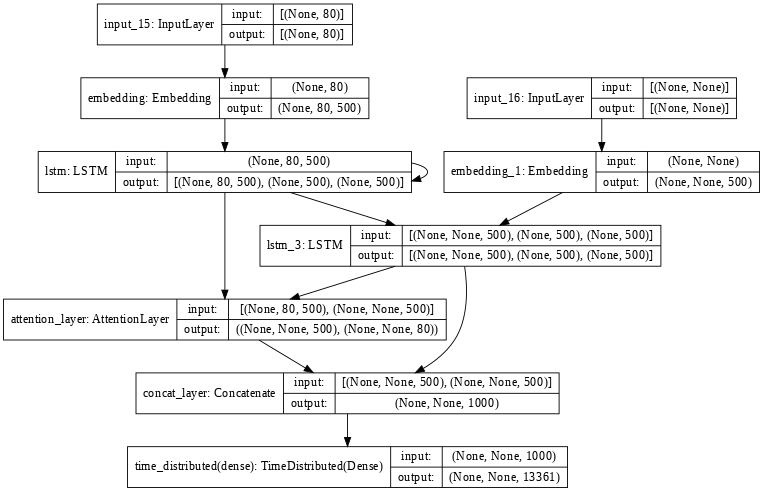

In [74]:
keras.utils.plot_model(model, dpi=64, show_shapes=True)

### Compiling the model

For the loss function we are going to use `sparse_categorical_cross_entropy` and the optimizer will be `rmsprop`


In [75]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

### Callbacks

For the callbacks we are going to use the `Early Stopping` call back that will monitor the validation loss.

In [84]:
early_stoping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

### Training the model

In [86]:
history=model.fit([x_train_tokens,y_train_tokens[:,:-1]], 
                  y_train_tokens.reshape(y_train_tokens.shape[0],y_train_tokens.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[early_stoping],
                  batch_size=1024, 
                  validation_data=([x_val_tokens, y_val_tokens[:,:-1]],
                                                    y_val_tokens.reshape(y_val_tokens.shape[0],y_val_tokens.shape[1], 1)[:,1:])
                  )

Epoch 1/50
70/70 [==============================] - 229s 3s/step - loss: 2.3627 - val_loss: 2.3504
Epoch 2/50
34/70 [=============>................] - ETA: 1:53 - loss: 2.2505

KeyboardInterrupt: ignored

### Model evaluation on the test set

In [87]:
model.evaluate(x=[x_test_tokens, y_test_tokens[:,:-1]], y=y_test_tokens.reshape(y_test_tokens.shape[0],y_test_tokens.shape[1], 1)[:,1:]
               ,verbose=1, batch_size=1024)
                  

9/9 [==============================] - 9s 984ms/step - loss: 2.2668


2.266782760620117

### Ploting the model history

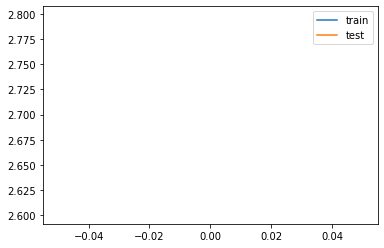

In [88]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

### Model inference


In [89]:
reverse_target_word_index=summary_tokenizer.index_word 
reverse_source_word_index=text_tokenizer.index_word 
target_word_index=summary_tokenizer.word_index

In [91]:
# encoder inference
encoder_model = keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_hidden_state_input = keras.Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = decoder_embbedding_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = keras.layers.Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = keras.Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [92]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['<sos>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='<eos>'):
            decoded_sentence += ' '+ sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == '<eos>' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [95]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['<sos>']) and i!=target_word_index['<eos>']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      print(input_seq)
      if(i!=0):
        print(i)
        newString = newString+reverse_source_word_index[i]+' '
    return newString

In [96]:
for i in range(len(x_val)):
  print("Review:", seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

made notta pasta spaghetti tonight first time fresh fish tomato sauce wonderful actually prefer pasta wheat pasta gluten intolerance continue buy notta pasta instead wheat pasta matter choice great stuff
m


KeyError: ignored

### Ref 

1. [comprehensive-guide-text-summarization-using-deep-learning-python](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)